In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------
# Load the dataset (adjust the path if necessary)
df = pd.read_csv('rotterdam.csv')

print(f"Original Dataset Shape: {df.shape}")

Original Dataset Shape: (2982, 16)


In [167]:
# ---------------------------------------------------------
# 2. TARGET ENGINEERING (The "Fix" for Censoring)
# ---------------------------------------------------------
# We want to predict: "Will the tumor recur within 5 years (1825 days)?"
# This transforms a Survival problem into a Binary Classification problem.

cutoff_days = 1825  # 5 years

# Step 2a: Identify Positive Cases (Recurred within 5 years)
# recur == 1 AND rtime <= 5 years
df['target'] = np.where((df['recur'] == 1) & (df['rtime'] <= cutoff_days), 1, 0)

# Step 2b: Identify Valid Negative Cases (Did NOT recur within 5 years)
# To be a valid '0', a patient must have been followed for > 5 years without recurrence.
# If they dropped out (censored) at 3 years, we DON'T know their 5-year status.
# We must EXCLUDE them to avoid confusion.

# Categorize 'nodes', 'er', and 'pgr' into binary categories
def categorize_er(er):
    if er <= 10:
        return '<= 10'
    else:
        return '>10'

def categorize_pgr(pgr):
    if pgr <= 10:
        return '<= 10'
    else:
        return '>10'

df['er'] = df['er'].apply(categorize_er);
df['pgr'] = df['pgr'].apply(categorize_pgr);

# Keep logic:
# 1. Target is 1 (We know they recurred early)
# 2. rtime > 1825 (We know they survived past 5 years free of disease)
valid_rows_mask = (df['target'] == 1) | (df['rtime'] > cutoff_days)

df_clean = df[valid_rows_mask].copy()

print(f"Filtered Dataset Shape (Removing early censored): {df_clean.shape}")
print(f"Class Balance:\n{df_clean['target'].value_counts(normalize=True)}")

Filtered Dataset Shape (Removing early censored): (2355, 17)
Class Balance:
target
0    0.667091
1    0.332909
Name: proportion, dtype: float64


In [168]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
# ---------------------------------------------------------
# UPGRADE 1: ROBUST EVALUATION (K-Fold CV)
# ---------------------------------------------------------
# We use StratifiedKFold to maintain the % of recurrence cases in every fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

# ---------------------------------------------------------
# 3. FEATURE SELECTION & PREPROCESSING
# ---------------------------------------------------------
# Based on Royston & Altman (2013) and your dataset metadata
# We exclude 'rtime', 'recur', 'dtime', 'death' to prevent data leakage.
# We exclude 'pid' and 'hospital_id' as they are identifiers.

features_num = ['age', 'nodes']
features_cat = ['size', 'grade', 'pgr', 'er', 'meno', 'hormon', 'chemo']

X = df_clean[features_num + features_cat]
y = df_clean['target']

# Preprocessing Pipeline
# - Numeric: Standard Scaling (helps Logistic Regression convergence)
# - Categorical: One-Hot Encoding (converts 'size' and 'grade' to dummy vars)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_num),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), features_cat)
    ])

In [169]:
# ---------------------------------------------------------
# 4. SPLITTING DATA
# ---------------------------------------------------------
# Stratify ensures we keep the same proportion of Recurrence/No-Recurrence in split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234, stratify=y
)

In [170]:
# ---------------------------------------------------------
# 5. BASELINE MODEL: LOGISTIC REGRESSION
# ---------------------------------------------------------
# Using a Pipeline to bundle preprocessing and modeling
# class_weight='balanced' helps if recurrence is rare
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=1234, max_iter=1000, class_weight='balanced'))
])

# Calculate accuracy across 5 folds
cv_scores = cross_val_score(model_pipeline, X, y, cv=cv, scoring='roc_auc')

print(f"--- Cross-Validation Results (Standard LR) ---")
print(f"AUC Scores for each fold: {cv_scores}")
print(f"Mean AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")
print("This is a much more reliable estimate of performance than a single split.\n")

# Fit baseline model on training data for test evaluation
print("--- Training Baseline Logistic Regression on Train Split ---")
model_lr = model_pipeline.fit(X_train, y_train)

# ---------------------------------------------------------
# UPGRADE 2: REGULARIZATION (Lasso / L1) - From Lab V
# ---------------------------------------------------------
# LogisticRegressionCV automatically finds the best 'C' (inverse of regularization strength)
# penalty='l1' is Lasso, solver='liblinear' supports L1
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegressionCV(
        cv=5, 
        penalty='l1', 
        solver='liblinear', 
        class_weight='balanced',
        max_iter=1000,
        random_state=1234
    ))
])

print("--- Training Lasso Model (Feature Selection) ---")
lasso_pipeline.fit(X_train, y_train)

--- Cross-Validation Results (Standard LR) ---
AUC Scores for each fold: [0.75915751 0.78667492 0.83870542 0.78759787 0.81973914]
Mean AUC: 0.798 (+/- 0.028)
This is a much more reliable estimate of performance than a single split.

--- Training Baseline Logistic Regression on Train Split ---
--- Training Lasso Model (Feature Selection) ---


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [171]:
# ---------------------------------------------------------
# INTERPRETATION: Which features survived Lasso?
# ---------------------------------------------------------
# Get the model from the pipeline
lasso_model = lasso_pipeline.named_steps['classifier']

# Get feature names after OneHotEncoding
feature_names_out = (lasso_pipeline.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(features_cat))
all_feature_names = features_num + list(feature_names_out)

# Get Coefficients
coeffs = lasso_model.coef_[0]

# Create a DataFrame to view them
coeff_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coeffs})
coeff_df['Odds_Ratio'] = np.exp(coeff_df['Coefficient'])

# Filter for non-zero coefficients (Variables Lasso decided to keep)
selected_features = coeff_df[coeff_df['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)

print("\n--- Features Selected by Lasso (Non-Zero Coefficients) ---")
print(selected_features)

print("\n--- Features Eliminated by Lasso (Coefficient ~ 0) ---")
print(coeff_df[coeff_df['Coefficient'] == 0])


--- Features Selected by Lasso (Non-Zero Coefficients) ---
     Feature  Coefficient  Odds_Ratio
1      nodes     0.918305    2.505040
4    grade_3     0.444627    1.559908
0        age    -0.080307    0.922833
5    pgr_>10    -0.185944    0.830320
2  size_<=20    -0.617022    0.539549

--- Features Eliminated by Lasso (Coefficient ~ 0) ---
    Feature  Coefficient  Odds_Ratio
3  size_>50          0.0         1.0
6    er_>10          0.0         1.0
7    meno_1          0.0         1.0
8  hormon_1          0.0         1.0
9   chemo_1          0.0         1.0



--- Model Evaluation (Test Set) ---
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       314
           1       0.58      0.73      0.65       157

    accuracy                           0.74       471
   macro avg       0.71      0.73      0.72       471
weighted avg       0.76      0.74      0.74       471



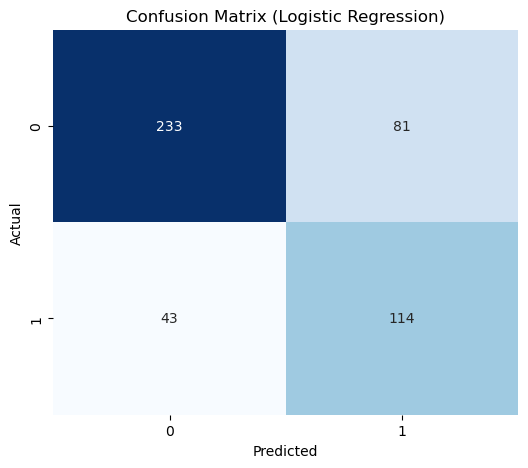

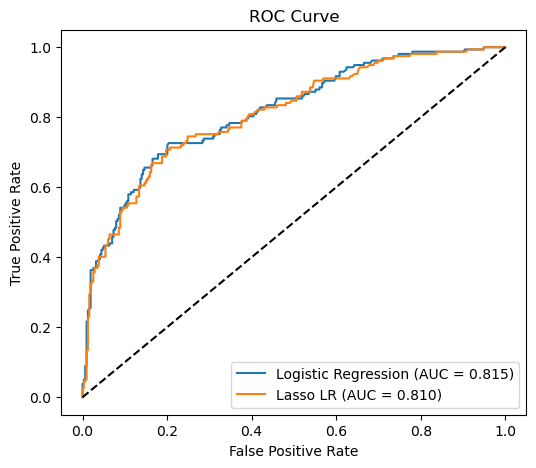

In [172]:
# ---------------------------------------------------------
# 6. EVALUATION
# ---------------------------------------------------------
# Predictions
y_pred = model_lr.predict(X_test)
y_prob = model_lr.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Metrics
print("\n--- Model Evaluation (Test Set) ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve (Baseline LR)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Lasso ROC (trained on train split)
y_prob_lasso = lasso_pipeline.predict_proba(X_test)[:, 1]
auc_lasso = roc_auc_score(y_test, y_prob_lasso)
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_prob_lasso)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc:.3f})")
plt.plot(fpr_lasso, tpr_lasso, label=f"Lasso LR (AUC = {auc_lasso:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [173]:
# ---------------------------------------------------------
# 7. INTERPRETATION (Coefficients)
# ---------------------------------------------------------
# Extracting feature names after OneHotEncoding is a bit tricky but useful
feature_names = features_num + list(model_lr.named_steps['preprocessor']
                                     .named_transformers_['cat']
                                     .get_feature_names_out(features_cat))

coeffs = model_lr.named_steps['classifier'].coef_[0]

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coeffs})
coef_df['Abs_Coeff'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coeff', ascending=False)

print("\n--- Top Predictive Features (Log-Odds) ---")
print(coef_df[['Feature', 'Coefficient']].head(10))


--- Top Predictive Features (Log-Odds) ---
     Feature  Coefficient
1      nodes     1.028316
2  size_<=20    -0.770100
4    grade_3     0.711969
5    pgr_>10    -0.419713
3   size_>50     0.386967
8   hormon_1    -0.306903
0        age    -0.247161
7     meno_1     0.172528
9    chemo_1    -0.135114
6     er_>10     0.069780


--- Linearity Check Results (5-Fold CV) ---
1. Linear 'nodes' AUC: 0.7982 (+/- 0.026)
2. Log(nodes+1)   AUC: 0.7975 (+/- 0.027)
>> CONCLUSION: The Linear model performs effectively the same.


C:\Users\ricca\AppData\Local\Temp\ipykernel_11416\2241799963.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_clean.groupby('nodes_bin')[['target', 'prob_linear', 'prob_log']].mean()


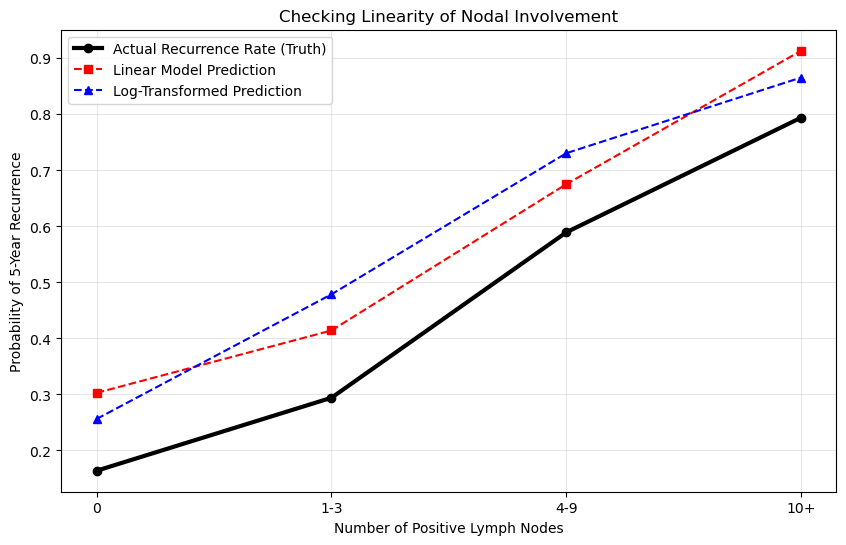

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ---------------------------------------------------------
# 1. PREPARE THE TRANSFORMATION
# ---------------------------------------------------------
# Royston & Altman often suggest log transformations for skewed count data
# We use log1p (log(x + 1)) because nodes can be 0.
df_clean['nodes_log'] = np.log1p(df_clean['nodes'])

# Define our two competitors
features_base = ['grade', 'age', 'pgr', 'size', 'nodes']      # Current Model
features_log  = ['grade', 'age', 'pgr', 'size', 'nodes_log']  # Transformed Model

# Define Categorical/Numeric lists for the pipeline
cat_vars = ['size', 'grade', 'pgr'] # pgr contains strings like '>10', so it's categorical
num_vars_base = ['age', 'nodes']
num_vars_log  = ['age', 'nodes_log']

# ---------------------------------------------------------
# 2. RUN THE COMPARISON (Cross-Validation)
# ---------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
y = df_clean['target']

def get_auc(features, num_vars):
    # Dynamic Preprocessor
    preproc = ColumnTransformer([
        ('num', StandardScaler(), num_vars),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_vars)
    ])
    
    pipe = Pipeline([
        ('preproc', preproc),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ])
    
    scores = cross_val_score(pipe, df_clean[features], y, cv=cv, scoring='roc_auc')
    return scores

# Calculate
scores_linear = get_auc(features_base, num_vars_base)
scores_log    = get_auc(features_log, num_vars_log)

print(f"--- Linearity Check Results (5-Fold CV) ---")
print(f"1. Linear 'nodes' AUC: {scores_linear.mean():.4f} (+/- {scores_linear.std():.3f})")
print(f"2. Log(nodes+1)   AUC: {scores_log.mean():.4f} (+/- {scores_log.std():.3f})")

if scores_log.mean() > scores_linear.mean():
    print(">> CONCLUSION: The Log-transformation IMPROVES the model. The relationship is likely non-linear.")
else:
    print(">> CONCLUSION: The Linear model performs effectively the same.")

# ---------------------------------------------------------
# 3. VISUALIZATION (The "Plot" for your Report)
# ---------------------------------------------------------
# We will bin 'nodes' and check the actual recurrence rate vs predicted probability
plt.figure(figsize=(10, 6))

# Bin nodes into groups: 0, 1-3, 4-9, 10+
df_clean['nodes_bin'] = pd.cut(df_clean['nodes'], bins=[-1, 0, 3, 9, 100], labels=['0', '1-3', '4-9', '10+'])

# Calculate Mean Predicted Probability for Linear vs Log model
# (Refit on full data for plotting)
def fit_predict(features, num_vars):
    preproc = ColumnTransformer([
        ('num', StandardScaler(), num_vars),
        ('cat', OneHotEncoder(drop='first'), cat_vars)
    ])
    pipe = Pipeline([('preproc', preproc), ('clf', LogisticRegression(class_weight='balanced'))])
    pipe.fit(df_clean[features], y)
    return pipe.predict_proba(df_clean[features])[:, 1]

df_clean['prob_linear'] = fit_predict(features_base, num_vars_base)
df_clean['prob_log']    = fit_predict(features_log, num_vars_log)

# Group by bin and plot
grouped = df_clean.groupby('nodes_bin')[['target', 'prob_linear', 'prob_log']].mean()

plt.plot(grouped.index, grouped['target'], 'o-', color='black', label='Actual Recurrence Rate (Truth)', linewidth=3)
plt.plot(grouped.index, grouped['prob_linear'], 's--', color='red', label='Linear Model Prediction')
plt.plot(grouped.index, grouped['prob_log'], '^--', color='blue', label='Log-Transformed Prediction')

plt.title("Checking Linearity of Nodal Involvement")
plt.ylabel("Probability of 5-Year Recurrence")
plt.xlabel("Number of Positive Lymph Nodes")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [175]:
import statsmodels.api as sm

# ---------------------------------------------------------
# STEP B: POST-SELECTION INFERENCE (Refitting for P-values)
# ---------------------------------------------------------
# 1. Select the features identified by Lasso
# (Note: We must handle categorical encoding manually for statsmodels)

# Create a clean dataframe with just the selected raw columns
selected_cols = ['nodes', 'grade', 'age', 'pgr', 'size']
X_refined = df_clean[selected_cols].copy()

# Manual Encoding for Statsmodels (Safety check)
# Convert 'size' to binary if it isn't already (Lasso picked size_<=20)
X_refined['size_small'] = (X_refined['size'] == '<=20').astype(int)
X_refined = X_refined.drop('size', axis=1) # Drop original

# Ensure 'grade' is numeric or dummy encoded
# If grade is 2,3, it's fine as ordinal, or use dummies if you prefer
# Let's treat grade as continuous (1,2,3) for simplicity or create dummy for Grade 3
X_refined['grade_3'] = (X_refined['grade'] == 3).astype(int)
X_refined = X_refined.drop('grade', axis=1)

# Encode 'pgr' categorical variable to numeric
X_refined['pgr_gt10'] = (X_refined['pgr'] == '>10').astype(int)
X_refined = X_refined.drop('pgr', axis=1)

# Add Constant (Intercept) - Statsmodels requires this explicitly!
X_refined = sm.add_constant(X_refined)
y_refined = df_clean['target']

# 2. Fit Standard Logistic Regression (No Penalty)
logit_model = sm.Logit(y_refined, X_refined)
result = logit_model.fit()

# 3. Get Summary
print(result.summary())

# 4. Extract Odds Ratios and CI for Report
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['CI_Lower', 'CI_Upper', 'Odds Ratio']
# Exponentiate to get ORs
odds_ratios = np.exp(conf)

print("\n--- FINAL REPORT TABLE (Odds Ratios & 95% CI) ---")
print(odds_ratios)

Optimization terminated successfully.
         Current function value: 0.509815
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 2355
Model:                          Logit   Df Residuals:                     2349
Method:                           MLE   Df Model:                            5
Date:                Sun, 11 Jan 2026   Pseudo R-squ.:                  0.1987
Time:                        03:23:21   Log-Likelihood:                -1200.6
converged:                       True   LL-Null:                       -1498.3
Covariance Type:            nonrobust   LLR p-value:                2.028e-126
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6065      0.260     -2.336      0.019      -1.115      -0.098
nodes          0.2122      0.

In [176]:
import statsmodels.api as sm

# ---------------------------------------------------------
# FINAL MODEL TASK 1: RECURRENCE
# ---------------------------------------------------------

# 1. Define the Final Feature Set (Using the Winner: nodes_log)
# We include 'pgr' because Lasso selected it earlier.
# We include 'size_<=20' because Lasso selected it earlier.
final_features = ['nodes_log', 'grade', 'size', 'age', 'pgr']

# 2. Prepare Data for Statsmodels (Manual Encoding)
X_final = df_clean[final_features].copy()

# A. Handle Categorical: Size
# Lasso selected 'size_<=20' as the protective factor.
# We create a binary variable: 1 if size <= 20, 0 otherwise
X_final['size_small'] = (X_final['size'] == '<=20').astype(int)
X_final = X_final.drop('size', axis=1)

# B. Handle Categorical: Grade
# We treat Grade 2 and 3 as risk factors against Grade 1 (Baseline)
grade_dummies = pd.get_dummies(X_final['grade'], prefix='grade', drop_first=True, dtype=int)
X_final = pd.concat([X_final, grade_dummies], axis=1)
X_final = X_final.drop('grade', axis=1)

# C. Handle Categorical: PGR (Binary)
X_final['pgr_gt10'] = (X_final['pgr'] == '>10').astype(int)
X_final = X_final.drop('pgr', axis=1)

# D. Add Intercept (Required for Statsmodels)
X_final = sm.add_constant(X_final)
y_final = df_clean['target']

# 3. Fit the Final Model
logit_final = sm.Logit(y_final, X_final).fit()

# 4. Generate the Report Table
params = logit_final.params
conf = logit_final.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['95% CI Lower', '95% CI Upper', 'Odds Ratio']

# Exponentiate to get Odds Ratios instead of Log-Odds
final_table = np.exp(conf)
final_table['P-Value'] = logit_final.pvalues

print("\n=== TASK 1 FINAL REPORT TABLE ===")
print(final_table.round(3))

Optimization terminated successfully.
         Current function value: 0.501355
         Iterations 6

=== TASK 1 FINAL REPORT TABLE ===
            95% CI Lower  95% CI Upper  Odds Ratio  P-Value
const              0.238         0.670       0.399    0.001
nodes_log          2.442         3.053       2.731    0.000
age                0.979         0.995       0.987    0.001
size_small         0.404         0.621       0.501    0.000
grade_3            1.534         2.524       1.968    0.000
pgr_gt10           0.547         0.834       0.675    0.000


Optimization terminated successfully.
         Current function value: 0.509400
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 2355
Model:                          Logit   Df Residuals:                     2348
Method:                           MLE   Df Model:                            6
Date:                Sun, 11 Jan 2026   Pseudo R-squ.:                  0.1993
Time:                        03:27:42   Log-Likelihood:                -1199.6
converged:                       True   LL-Null:                       -1498.3
Covariance Type:            nonrobust   LLR p-value:                8.833e-126
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.7110      0.272     -2.616      0.009      -1.244      -0.178
nodes             0.

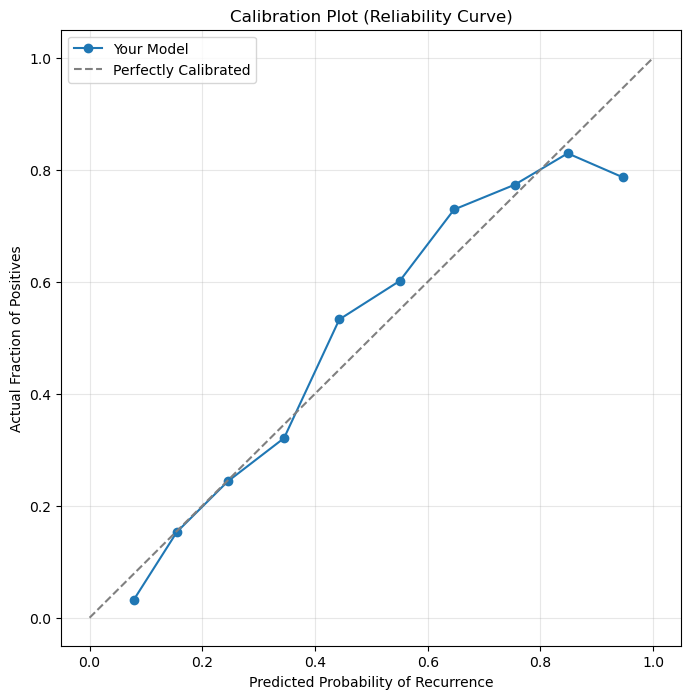

Brier Score (Lower is better): 0.1659


In [ ]:
import statsmodels.formula.api as smf
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# ---------------------------------------------------------
# STEP 1: TEST INTERACTION (Nodes * Grade)
# ---------------------------------------------------------
# We use 'smf' (formula API) because it handles interactions (:) easily
# Formula: target ~ nodes + age + size_small + grade_3 + pgr_gt10 + INTERACTION

# Prepare data for formula (ensure columns are named correctly without spaces)
df_interact = df_clean.copy()
df_interact['size_small'] = (df_interact['size'] == '<=20').astype(int)
df_interact['grade_3'] = (df_interact['grade'] == 3).astype(int)
df_interact['pgr_gt10'] = (df_interact['pgr'] == '>10').astype(int)

# Fit model WITH interaction
model_interaction = smf.logit(
    formula='target ~ nodes + age + size_small + grade_3 + pgr_gt10 + nodes:grade_3',
    data=df_interact
).fit()

print(model_interaction.summary())

# CHECK: Look at the P-value for 'nodes:grade_3'
# If P < 0.05 -> The interaction is significant (KEEP IT).
# If P > 0.05 -> The interaction is noise (DISCARD IT).

# ---------------------------------------------------------
# STEP 2: CALIBRATION PLOT (Goodness of Fit)
# ---------------------------------------------------------
# A model can have high AUC but be "miscalibrated" (e.g., predicting 80% risk when real risk is 40%).
# This is crucial for clinical models.

# Get probabilities from your BEST model (assuming Linear was best)
# We need to refit sklearn model for easy plotting or use statsmodels predictions
y_prob = model_interaction.predict(df_interact) # or use your previous model if interaction failed

prob_true, prob_pred = calibration_curve(df_interact['target'], y_prob, n_bins=10)

plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', label='Your Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability of Recurrence')
plt.ylabel('Actual Fraction of Positives')
plt.title('Calibration Plot (Reliability Curve)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Brier Score (Lower is better): {brier_score_loss(df_interact['target'], y_prob):.4f}")